In [14]:
import pandas as pd
from datetime import datetime as DateTime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Configurando los estílos de los gráficos
plt.ioff()
sns.set_context('talk')
sns.set_style("whitegrid")

## Adquisición de Datos

In [15]:
df = pd.read_csv('data/defunciones.csv')

In [16]:
df

,FECHA_CORTE,UUID,FECHA_FALLECIMIENTO,EDAD_DECLARADA,SEXO,CLASIFICACION_DEF,UBIGEO,DEPARTAMENTO,PROVINCIA,DISTRITO
0,20210621,7320cabdc1aaca6c59014cae76a134e6,20200519,89,MASCULINO,Criterio SINADEF,150201.0,LIMA REGION,BARRANCA,BARRANCA
1,20210621,e81602051997ace8340bb8c18fe24c65,20200517,90,MASCULINO,Criterio SINADEF,150605.0,LIMA REGION,HUARAL,CHANCAY
2,20210621,cecdbf10074dbc011ae05b3cbd320a6f,20200521,91,MASCULINO,Criterio SINADEF,150801.0,LIMA REGION,HUAURA,HUACHO
3,20210621,71ecb6bccb248b0bb2ac72ed51b5e979,20200529,81,MASCULINO,Criterio SINADEF,150514.0,LIMA REGION,CAÑETE,SAN LUIS
4,20210621,566af4276cbe9359abe93f9aa86396c3,20200529,82,MASCULINO,Criterio SINADEF,150608.0,LIMA REGION,HUARAL,PACARAOS
...,...,...,...,...,...,...,...,...,...,...
190901,20210621,cc4d3990217c46af64e0477e83b8f1aa,20210608,60,MASCULINO,Criterio SINADEF,80101.0,CUSCO,CUSCO,CUSCO
190902,20210621,dee2574cc2730439b12739083afa786b,20210608,69,FEMENINO,Criterio virológico,150132.0,LIMA METROPOLITANA,LIMA,SAN JUAN DE LURIGANCHO
190903,20210621,ed9fa3bf3caa34d83ef42effd53b8910,20210608,78,MASCULINO,Criterio SINADEF,221005.0,SAN MARTIN,TOCACHE,UCHIZA
190904,20210621,13951daf0b0ced00276aafb1d31cc551,20210608,64,FEMENINO,Criterio virológico,230101.0,TACNA,TACNA,TACNA


## Transformación de Datos

### Calculando defunciones por día

In [17]:
gb = df.groupby(by="FECHA_FALLECIMIENTO")

In [18]:
data = []
for i in gb:
    data.append(
        {
            'date': DateTime.strptime(str(i[0]),'%Y%m%d'),
            'count': len(i[1])
        }
    )

daily = pd.DataFrame(data, columns=['date','count'])
daily.head(5)

,date,count
0,2020-03-03,1
1,2020-03-07,1
2,2020-03-11,1
3,2020-03-14,2
4,2020-03-16,4


### Calculando defunciones por semana

In [19]:
data = daily.copy()
data['low'] = data['count'].rolling(7).min()
data['high'] = data['count'].rolling(7).max()

In [20]:
weekly = data.set_index(data['date']).resample('W').agg({'date': 'last','high': 'max', 'low': 'min','count': 'last'}).reset_index(drop=True)[['date','high','low','count']]
weekly.head(5)

,date,high,low,count
0,2020-03-07,NaN,NaN,1
1,2020-03-14,NaN,NaN,2
2,2020-03-22,6.0,1.0,5
3,2020-03-29,18.0,4.0,18
4,2020-04-05,60.0,6.0,43


## Visualización de Datos

In [21]:
ema_count = daily['count'].ewm(com=9,adjust=False).mean()

<Figure size 432x288 with 0 Axes>

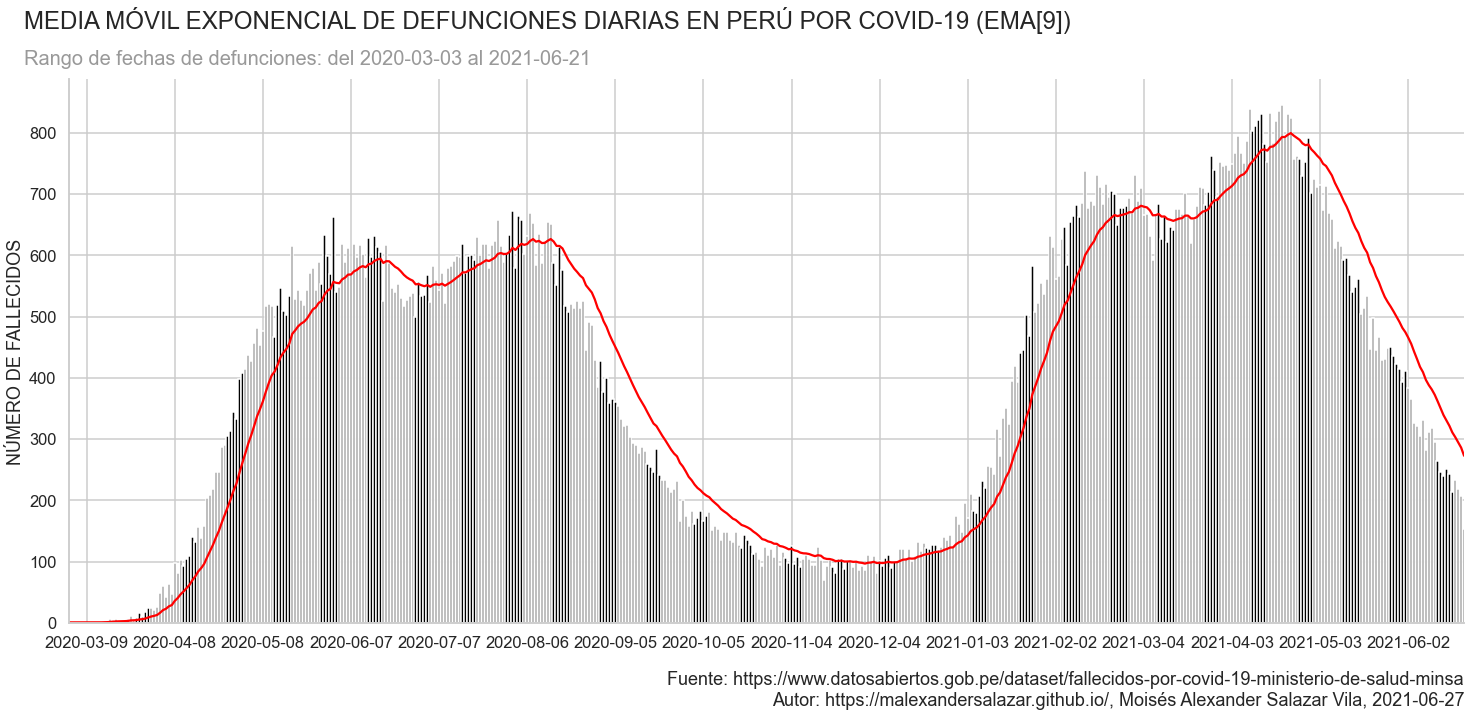

In [22]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'MEDIA MÓVIL EXPONENCIAL DE DEFUNCIONES DIARIAS EN PERÚ POR COVID-19 (EMA[9])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=30)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.bar(daily['date'], daily['count'], color='#000')
axs.plot(daily['date'], ema_count, color='r')

axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('NÚMERO DE FALLECIDOS')

sns.despine(left=False, bottom=False)

filename = 'dist/DEFUNCIONES.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [23]:
low_in_period = weekly['low'].rolling(10).min()
high_in_period = weekly['high'].rolling(10).max()
percentK = pd.Series((weekly['count'] - low_in_period) / (high_in_period - low_in_period) * 100, name='%K')
percentD = pd.Series(percentK.rolling(6).mean(), name='%D')
percentDn = pd.Series(percentD.rolling(6).mean(), name='%Dn')

<Figure size 432x288 with 0 Axes>

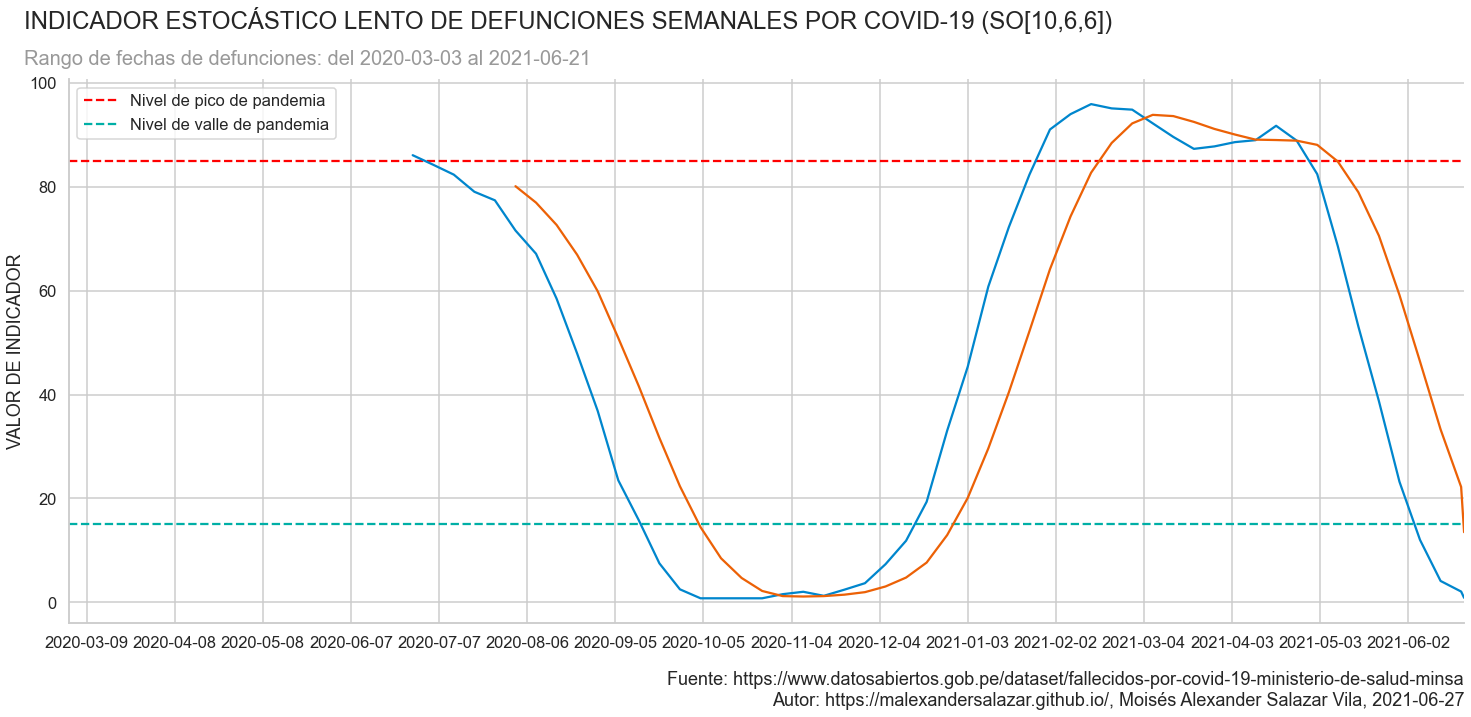

In [24]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR ESTOCÁSTICO LENTO DE DEFUNCIONES SEMANALES POR COVID-19 (SO[10,6,6])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=30)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], percentD, color='#0086CD')
axs.plot(weekly['date'], percentDn, color='#EC6106')
axs.hlines(85, daily["date"].iat[0], daily["date"].iat[-1], color='r', linestyles= 'dashed', label='Nivel de pico de pandemia')
axs.hlines(15, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de valle de pandemia')

# axs.set_xlim((weekly["date"].iat[PERIOD],daily["date"].iat[-1]))
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/SO.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

In [25]:
weekly_delta = weekly['count'].diff()
weekly_up = weekly_delta.clip(lower=0)
weekly_down = -1*weekly_delta.clip(upper=0)

ema_up = weekly_up.ewm(com=14,adjust=False).mean()
ema_down = weekly_down.ewm(com=14,adjust=False).mean()
weekly_rs = ema_up/ema_down
weekly_rsi = 100-(100/(1+weekly_rs))
weekly_rsi.fillna(method='bfill',inplace=True)

<Figure size 432x288 with 0 Axes>

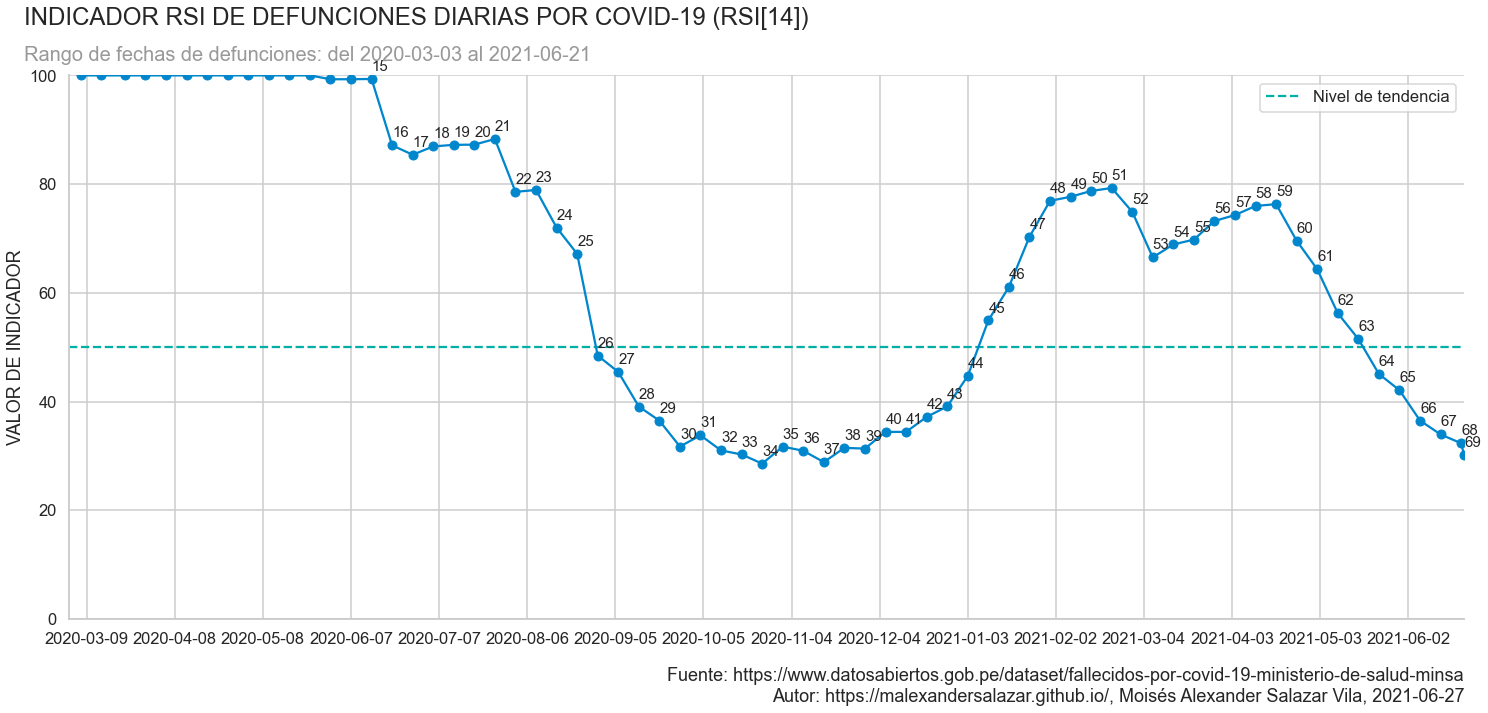

In [26]:
plt.clf()

fig, axs = plt.subplots(figsize=(25,10))
plt.figtext(0.1,0.95, 'INDICADOR RSI DE DEFUNCIONES SEMANALES POR COVID-19 (RSI[14])', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Rango de fechas de defunciones: del {} al {}'.format(f'{daily["date"].iat[0]:%Y-%m-%d}',f'{daily["date"].iat[-1]:%Y-%m-%d}'), ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

formatter = mdates.DateFormatter("%Y-%m-%d")
locator = mdates.DayLocator(interval=30)

axs.xaxis.set_major_formatter(formatter)
axs.xaxis.set_major_locator(locator)

axs.plot(weekly['date'], weekly_rsi, 'o-', color='#0086CD')
axs.hlines(50, daily["date"].iat[0], daily["date"].iat[-1], color='#00AFA6', linestyles= 'dashed', label='Nivel de tendencia')

for i in range(14,len(weekly['date'])):
    axs.text(weekly['date'].iat[i], weekly_rsi.iat[i] + 1.5, str(i+1), fontsize='small')

axs.set_ylim(0,100)
axs.set_xlim((daily["date"].iat[0],daily["date"].iat[-1]))
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/RSI.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)